In [112]:
# IMPORTS & SETUP (Run once at the top)
import os
import glob
import zipfile
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


print('\nEnvironment ready. Run the steps in order.\n')


Environment ready. Run the steps in order.



In [113]:
import pandas as pd

# Load the dataset
data = pd.read_csv(r"C:\Users\nandana\Downloads\archive (7)\Food_Delivery_Times.csv")
data.head()
df = data.copy()
df.head()
# Shape of dataset
print("Shape:", df.shape)

# Column names
print("\nColumns:", df.columns.tolist())

# First 5 rows
print("\nHead:")
print(df.head())

# Info (data types)
print("\nInfo:")
print(df.info())

# Summary statistics
print("\nDescribe:")
print(df.describe())

# Missing values
print("\nMissing values:")
print(df.isnull().sum())

# Duplicate rows
print("\nDuplicate rows:", df.duplicated().sum())


Shape: (1000, 9)

Columns: ['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Delivery_Time_min']

Head:
   Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0       522         7.93   Windy           Low   Afternoon      Scooter   
1       738        16.42   Clear        Medium     Evening         Bike   
2       741         9.52   Foggy           Low       Night      Scooter   
3       661         7.44   Rainy        Medium   Afternoon      Scooter   
4       412        19.03   Clear           Low     Morning         Bike   

   Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
0                    12                     1.0                 43  
1                    20                     2.0                 84  
2                    28                     1.0                 59  
3                     5                     1.0                 37  
4           

In [114]:
# 1) Strip whitespace in text columns
str_cols = df.select_dtypes(include=['object']).columns
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()


In [115]:
# 2) Remove exact duplicates
before = len(df)
df = df.drop_duplicates()
print("Duplicates removed:", before - len(df))


Duplicates removed: 0


In [116]:
# 3) Rename important columns to simple names
df = df.rename(columns={
    'Distance_km': 'distance_km',
    'Delivery_Time_min': 'delivery_time_minutes',
    'Traffic_Level': 'traffic',
    'Time_of_Order': 'order_time',
    'Courier_Experience_yrs': 'courier_experience_yrs'
})

In [117]:
# 4) Make numeric columns numeric
if 'distance_km' in df.columns:
    df['distance_km'] = pd.to_numeric(df['distance_km'], errors='coerce')

if 'delivery_time_minutes' in df.columns:
    df['delivery_time_minutes'] = pd.to_numeric(
        df['delivery_time_minutes'].astype(str).str.extract(r'(\d+\.?\d*)')[0],
        errors='coerce'
    )

In [118]:
# 5) Handle missing values
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object']).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna('unknown')

In [119]:

# 6) Remove impossible delivery times
if 'delivery_time_minutes' in df.columns:
    before = len(df)
    df = df[(df['delivery_time_minutes'] > 0) & (df['delivery_time_minutes'] < 1000)]
    print("Impossible delivery times removed:", before - len(df))

Impossible delivery times removed: 0


In [120]:
print(df.head())
print("\nMissing values after cleaning:")
print(df.isnull().sum())

   Order_ID  distance_km Weather traffic Time_of_Day Vehicle_Type  \
0       522         7.93   Windy     Low   Afternoon      Scooter   
1       738        16.42   Clear  Medium     Evening         Bike   
2       741         9.52   Foggy     Low       Night      Scooter   
3       661         7.44   Rainy  Medium   Afternoon      Scooter   
4       412        19.03   Clear     Low     Morning         Bike   

   Preparation_Time_min  courier_experience_yrs  delivery_time_minutes  
0                    12                     1.0                     43  
1                    20                     2.0                     84  
2                    28                     1.0                     59  
3                     5                     1.0                     37  
4                    16                     5.0                     68  

Missing values after cleaning:
Order_ID                  0
distance_km               0
Weather                   0
traffic                   0
Tim

In [121]:
# STEP 2.5 — Outlier Detection & Removal (Simple)

import numpy as np

# Select numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns

print("Numeric columns:", num_cols.tolist())

# Check IQR-based outliers for delivery time
Q1 = df['delivery_time_minutes'].quantile(0.25)
Q3 = df['delivery_time_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print("Delivery Time IQR Limits:", lower_limit, upper_limit)

# Count how many outliers
outliers = df[(df['delivery_time_minutes'] < lower_limit) | (df['delivery_time_minutes'] > upper_limit)]
print("Outliers found:", len(outliers))

# Remove them
df = df[(df['delivery_time_minutes'] >= lower_limit) & (df['delivery_time_minutes'] <= upper_limit)]

print("New shape after removing outliers:", df.shape)


Numeric columns: ['Order_ID', 'distance_km', 'Preparation_Time_min', 'courier_experience_yrs', 'delivery_time_minutes']
Delivery Time IQR Limits: -4.0 116.0
Outliers found: 6
New shape after removing outliers: (994, 9)


In [122]:
# STEP 2.5 — Outlier Detection & Removal

import numpy as np

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    print(f"\nColumn: {column}")
    print("Lower limit:", lower_limit)
    print("Upper limit:", upper_limit)

    # count outliers
    outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
    print("Outliers found:", len(outliers))

    # remove outliers
    df_cleaned = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    print("Remaining rows:", df_cleaned.shape)

    return df_cleaned


# Apply to important columns
numeric_cols = ['delivery_time_minutes', 'distance_km']

for col in numeric_cols:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)



Column: delivery_time_minutes
Lower limit: -4.0
Upper limit: 116.0
Outliers found: 0
Remaining rows: (994, 9)

Column: distance_km
Lower limit: -9.7975
Upper limit: 29.7025
Outliers found: 0
Remaining rows: (994, 9)


In [123]:
df.isnull().sum()


Order_ID                  0
distance_km               0
Weather                   0
traffic                   0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
courier_experience_yrs    0
delivery_time_minutes     0
dtype: int64

In [124]:
#eda

Shape: (994, 9)

Columns: ['Order_ID', 'distance_km', 'Weather', 'traffic', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'courier_experience_yrs', 'delivery_time_minutes']


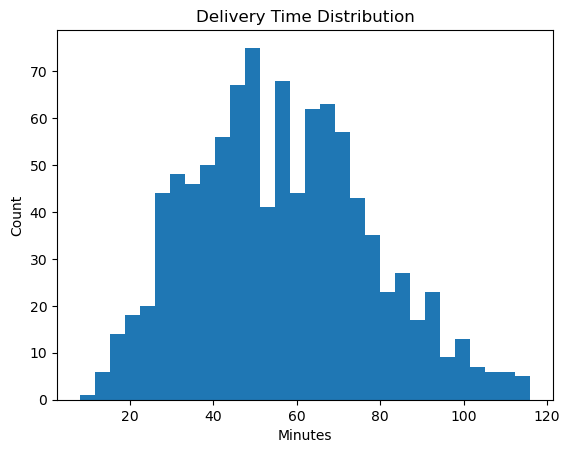

In [125]:

import pandas as pd
import matplotlib.pyplot as plt

# If you did not run Step 2 in the same notebook, uncomment:
# df = pd.read_csv("Food_Delivery_Times.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# --- 1) Distribution of Delivery Time ---
plt.hist(df['delivery_time_minutes'], bins=30)
plt.title("Delivery Time Distribution")
plt.xlabel("Minutes")
plt.ylabel("Count")
plt.show()

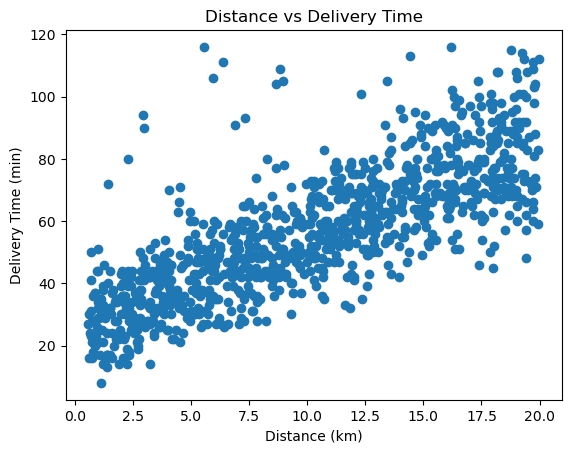

In [126]:
# --- 2) Distance vs Delivery Time ---
if 'distance_km' in df.columns:
    plt.scatter(df['distance_km'], df['delivery_time_minutes'])
    plt.title("Distance vs Delivery Time")
    plt.xlabel("Distance (km)")
    plt.ylabel("Delivery Time (min)")
    plt.show()
else:
    print("Column 'distance_km' not found.")

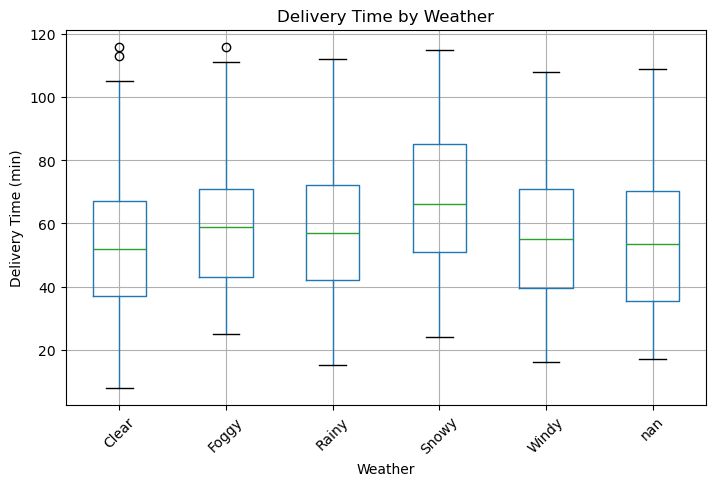

In [127]:

# --- 3) Boxplot of Delivery Time by Weather ---
if 'Weather' in df.columns:
    df.boxplot(column='delivery_time_minutes', by='Weather', figsize=(8,5), rot=45)
    plt.title("Delivery Time by Weather")
    plt.suptitle("")  # remove extra title
    plt.xlabel("Weather")
    plt.ylabel("Delivery Time (min)")
    plt.show()
else:
    print("Column 'weather' not found.")

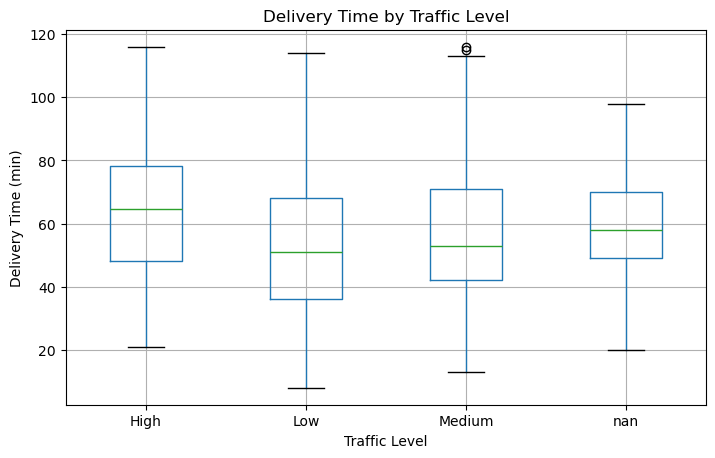

In [128]:
# --- 4) Boxplot of Delivery Time by Traffic ---
if 'traffic' in df.columns:
    df.boxplot(column='delivery_time_minutes', by='traffic', figsize=(8,5))
    plt.title("Delivery Time by Traffic Level")
    plt.suptitle("")
    plt.xlabel("Traffic Level")
    plt.ylabel("Delivery Time (min)")
    plt.show()
else:
    print("Column 'traffic' not found.")

In [129]:
# --- 5) Correlation (numerical columns only) ---
print("\nCorrelation with delivery time:")
print(df.corr(numeric_only=True)['delivery_time_minutes'].sort_values(ascending=False))


Correlation with delivery time:
delivery_time_minutes     1.000000
distance_km               0.788343
Preparation_Time_min      0.307307
Order_ID                 -0.043732
courier_experience_yrs   -0.086789
Name: delivery_time_minutes, dtype: float64


In [130]:
# feature engineering

In [131]:
# 1) Extract hour and day from order_time if it exists
if "order_time" in df.columns:
    df["order_time_parsed"] = pd.to_datetime(df["order_time"], errors="coerce")
    df["order_hour"] = df["order_time_parsed"].dt.hour
    df["order_day"] = df["order_time_parsed"].dt.dayofweek
else:
    # If no timestamp exists (your dataset may not have it)
    df["order_hour"] = -1
    df["order_day"] = -1

In [132]:
# 2) Weekend flag
df["is_weekend"] = df["order_day"].isin([5, 6]).astype(int)

In [133]:
# 3) Speed feature (distance ÷ time)
# Avoid division by zero
if "distance_km" in df.columns and "delivery_time_minutes" in df.columns:
    df["speed_km_per_hr"] = df["distance_km"] / (df["delivery_time_minutes"] / 60)
else:
    df["speed_km_per_hr"] = np.nan

In [134]:

# 4) Encode categorical columns (weather, traffic)
if "weather" in df.columns:
    df["weather"] = df["weather"].fillna("unknown")

if "traffic" in df.columns:
    df["traffic"] = df["traffic"].fillna("unknown")


In [135]:
# 5) Create dummies for ML model
df = pd.get_dummies(df, columns=["Weather", "traffic"], drop_first=True)

In [136]:
# 6) Replace any remaining missing values
df = df.fillna(df.median(numeric_only=True))
df = df.fillna("unknown")


In [137]:
print(df.head())

   Order_ID  distance_km Time_of_Day Vehicle_Type  Preparation_Time_min  \
0       522         7.93   Afternoon      Scooter                    12   
1       738        16.42     Evening         Bike                    20   
2       741         9.52       Night      Scooter                    28   
3       661         7.44   Afternoon      Scooter                     5   
4       412        19.03     Morning         Bike                    16   

   courier_experience_yrs  delivery_time_minutes  order_hour  order_day  \
0                     1.0                     43          -1         -1   
1                     2.0                     84          -1         -1   
2                     1.0                     59          -1         -1   
3                     1.0                     37          -1         -1   
4                     5.0                     68          -1         -1   

   is_weekend  speed_km_per_hr  Weather_Foggy  Weather_Rainy  Weather_Snowy  \
0           0      

In [138]:
# Encode Time_of_Day and Vehicle_Type
df = pd.get_dummies(df, columns=["Time_of_Day", "Vehicle_Type"], drop_first=True)


In [139]:
print(df.head())

   Order_ID  distance_km  Preparation_Time_min  courier_experience_yrs  \
0       522         7.93                    12                     1.0   
1       738        16.42                    20                     2.0   
2       741         9.52                    28                     1.0   
3       661         7.44                     5                     1.0   
4       412        19.03                    16                     5.0   

   delivery_time_minutes  order_hour  order_day  is_weekend  speed_km_per_hr  \
0                     43          -1         -1           0        11.065116   
1                     84          -1         -1           0        11.728571   
2                     59          -1         -1           0         9.681356   
3                     37          -1         -1           0        12.064865   
4                     68          -1         -1           0        16.791176   

   Weather_Foggy  ...  Weather_nan  traffic_Low  traffic_Medium  traffic_n

In [140]:
# Model Training

In [141]:
# STEP 5 — Model Training

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [142]:
# -----------------------
# 1) SELECT FEATURES
# -----------------------

feature_cols = [
    "distance_km",
    "Preparation_Time_min",
    "courier_experience_yrs",
    "speed_km_per_hr",
    "is_weekend",
    # weather + traffic + time_of_day dummies added earlier:
]

In [143]:
# Include all dummy (encoded) columns automatically
dummy_cols = [col for col in df.columns if 
              col.startswith("Weather_") or 
              col.startswith("traffic_") or
              col.startswith("Time_of_Day_") or
              col.startswith("Vehicle_Type_")]

feature_cols.extend(dummy_cols)

X = df[feature_cols]
y = df["delivery_time_minutes"]

In [144]:
# -----------------------
# 2) TRAIN-TEST SPLIT
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [145]:
# -----------------------
# 3) LINEAR REGRESSION
# -----------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)

In [146]:
# -----------------------
# 4) RANDOM FOREST
# -----------------------
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

In [147]:
# 5) EVALUATION FUNCTION
# -----------------------
def evaluate(model_name, y_true, y_pred):
    print(f"\n--- {model_name} ---")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R²:", r2_score(y_true, y_pred))

In [148]:
# 6) SHOW RESULTS
# -----------------------
evaluate("Linear Regression", y_test, lr_pred)
evaluate("Random Forest", y_test, rf_pred) 


--- Linear Regression ---
MAE: 4.611450365854829
RMSE: 7.0656484917785205
R²: 0.8992382477526416

--- Random Forest ---
MAE: 1.949932998324958
RMSE: 3.9541957234177825
R²: 0.9684421084415948


In [188]:
# STEP 6 — Predictions, Errors, Risk Levels

# 1) Predict delivery time for all rows
df["predicted_delivery_time"] = rf.predict(X)

# 2) Calculate prediction error
df["prediction_error"] = df["delivery_time_minutes"] - df["predicted_delivery_time"]
df["abs_error"] = df["prediction_error"].abs()

# 3) Create delay risk category (Low / Medium / High)
q1 = df["predicted_delivery_time"].quantile(0.33)
q2 = df["predicted_delivery_time"].quantile(0.66)

def risk(x):
    if x <= q1:
        return "Low"
    elif x <= q2:
        return "Medium"
    else:
        return "High"

df["delay_risk"] = df["predicted_delivery_time"].apply(risk)

# 4) Save final dataset for Power BI
df.to_csv("final_delivery_dataset.csv", index=False)

print("STEP 6 completed — final_delivery_dataset.csv created!")
df.head()


STEP 6 completed — final_delivery_dataset.csv created!


,Order_ID,distance_km,Preparation_Time_min,courier_experience_yrs,delivery_time_minutes,order_hour,order_day,is_weekend,speed_km_per_hr,Weather_Foggy,...,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Time_of_Day_nan,Vehicle_Type_Car,Vehicle_Type_Scooter,predicted_delivery_time,prediction_error,abs_error,delay_risk
0,522,7.93,12,1.0,43,-1,-1,0,11.065116,False,...,False,False,False,False,False,True,42.946667,0.053333,0.053333,Low
1,738,16.42,20,2.0,84,-1,-1,0,11.728571,False,...,True,False,False,False,False,False,83.626667,0.373333,0.373333,High
2,741,9.52,28,1.0,59,-1,-1,0,9.681356,True,...,False,False,True,False,False,True,59.186667,-0.186667,0.186667,Medium
3,661,7.44,5,1.0,37,-1,-1,0,12.064865,False,...,False,False,False,False,False,True,37.306667,-0.306667,0.306667,Low
4,412,19.03,16,5.0,68,-1,-1,0,16.791176,False,...,False,True,False,False,False,False,68.230000,-0.230000,0.230000,High


In [190]:
#####

In [192]:
#Check the first few predictions
df[["delivery_time_minutes", "predicted_delivery_time", "prediction_error"]].head()


,delivery_time_minutes,predicted_delivery_time,prediction_error
0,43,42.946667,0.053333
1,84,83.626667,0.373333
2,59,59.186667,-0.186667
3,37,37.306667,-0.306667
4,68,68.230000,-0.230000


In [194]:
#2. Check prediction accuracy with basic stats
print("Average Error:", df["abs_error"].mean())
print("Max Error:", df["abs_error"].max())
print("Min Error:", df["abs_error"].min())

Average Error: 1.0052012072434606
Max Error: 32.39666666666667
Min Error: 0.0


In [196]:
#3. Check distribution of errors
df["abs_error"].describe()

count    994.000000
mean       1.005201
std        2.057523
min        0.000000
25%        0.196667
50%        0.483333
75%        1.076667
max       32.396667
Name: abs_error, dtype: float64

In [198]:
def predict_delivery(distance_km, prep_time, exp_years, weather, traffic, time_of_day, vehicle):
    # Create empty row with all columns
    row = {col: 0 for col in X.columns}

    # Fill numeric values
    row["distance_km"] = distance_km
    row["Preparation_Time_min"] = prep_time
    row["courier_experience_yrs"] = exp_years

    # One-hot encoding (turn the category ON)
    weather_col = f"Weather_{weather}"
    traffic_col = f"traffic_{traffic}"
    tod_col = f"Time_of_Day_{time_of_day}"
    veh_col = f"Vehicle_Type_{vehicle}"

    if weather_col in row: row[weather_col] = 1
    if traffic_col in row: row[traffic_col] = 1
    if tod_col in row: row[tod_col] = 1
    if veh_col in row: row[veh_col] = 1

    # Convert to DF
    import pandas as pd
    row_df = pd.DataFrame([row])

    # Predict
    prediction = rf.predict(row_df)[0]
    return prediction


In [200]:
predict_delivery(
    distance_km = 5,
    prep_time = 15,
    exp_years = 2,
    weather = "Rainy",
    traffic = "Medium",
    time_of_day = "Evening",
    vehicle = "Scooter"
)


74.6

In [210]:
#Save model + feature list
import pickle

# Save your trained Random Forest model
with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Save feature columns used by the model
with open("feature_cols.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

print("MODEL SAVED SUCCESSFULLY!")



MODEL SAVED SUCCESSFULLY!


In [212]:
import pickle

with open("rf_model.pkl", "rb") as f:
    rf = pickle.load(f)

with open("feature_cols.pkl", "rb") as f:
    feature_cols = pickle.load(f)

print("MODEL LOADED SUCCESSFULLY!")


MODEL LOADED SUCCESSFULLY!


In [214]:
def predict_delivery(distance_km, prep_time, exp_years, weather, traffic, time_of_day, vehicle):
    row = {col: 0 for col in feature_cols}

    row["distance_km"] = distance_km
    row["Preparation_Time_min"] = prep_time
    row["courier_experience_yrs"] = exp_years

    weather_col = f"Weather_{weather}"
    traffic_col = f"traffic_{traffic}"
    tod_col = f"Time_of_Day_{time_of_day}"
    veh_col = f"Vehicle_Type_{vehicle}"

    if weather_col in row: row[weather_col] = 1
    if traffic_col in row: row[traffic_col] = 1
    if tod_col in row: row[tod_col] = 1
    if veh_col in row: row[veh_col] = 1

    import pandas as pd
    row_df = pd.DataFrame([row])

    prediction = rf.predict(row_df)[0]
    return prediction

# Try prediction
print(predict_delivery(5, 12, 2, "Rainy", "Medium", "Evening", "Scooter"))


75.46333333333334


In [216]:
import os
os.listdir()


['-1.14-windows.xml',
 '.anaconda',
 '.conda',
 '.condarc',
 '.continuum',
 '.eclipse',
 '.idlerc',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.keras',
 '.matplotlib',
 '.p2',
 '.spyder-py3',
 '.streamlit',
 '.vscode',
 '3D Objects',
 'anaconda3',
 'AppData',
 'Apple',
 'Application Data',
 'banking_case_connection_sql.ipynb',
 'city_delay_by_phase.csv',
 'Contacts',
 'Cookies',
 'crisis_negative_words.csv',
 'Customer segmentation .ipynb',
 'customers_cashback_elig.csv',
 'customers_reactivate.csv',
 'data',
 'DBSCAN.ipynb',
 'demand_pricing.ipynb',
 'demand_pricing_model.pkl',
 'demand_pricing_scaler.pkl',
 'Desktop',
 'df_master_cleaned-Copy1.csv',
 'df_master_cleaned.csv',
 'Documents',
 'Downloads',
 'eclipse-workspace',
 'employee_promotion.ipynb',
 'Favorites',
 'feature_cols.pkl',
 'final_delivery_dataset.csv',
 'frontend_iris.ipynb',
 'frontend_iris.py',
 'gensim-data',
 'gt_cac_merged.csv',
 'IntelGraphicsProfiles',
 'iris_knn_deploy.ipynb',
 'iris_scaler_sav',
 'Jedi

In [218]:
# final_delivery_dataset.csv